To Do:

        # - - - - - - To Do: - - - - - - 
        #    
        
        
        Change empty to size in class prealloc
        
        

        #    Supervised
             SVM
             DTW
             Gaussian Process Classification (GPC)
             Gauss Naive Bayes (or multinomial naive bayes)
             Adaboost
             Gradient Tree Boosting
             Use Voting Classifier
        #    
        #    Plots
        #    
        #    Document Like Scikit source
        #  
        #    Pep8
        #  Refactor
        
        Learn Hyper-Parameter Optimization Methods
        
        Put Desirable Methods in Class (at end)
    
            #    more Preprocessing
                Laplace:: Solve as 2nd order, forced by one, (I want the coefficients in the 'original' ODE) 
                Try Using other Clustering Methods
                Variance Thresholding via pipelining
            
        

To Examine:

    Make an Analogous "Which method works best" to run similar to the UCR program. (And try loads of them)

    Test things with Time-It.

    Laplace Analysis 
    
    


In [1]:
import numpy as np
from scipy import signal
from scipy.stats import linregress
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import csv
import re
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from scipy.signal import blackman
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.externals import joblib
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import operator
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier


style.use('ggplot')



from scipy.spatial.distance import euclidean

from fastdtw import fastdtw


In [2]:
train_data = np.genfromtxt('FordA_TRAIN', delimiter=',')[:,1:]
train_classes=np.genfromtxt('FordA_TRAIN', delimiter=',')[:,0]

test_data = np.genfromtxt('FordA_TEST', delimiter=',')[:,1:]
test_classes=np.genfromtxt('FordA_TEST', delimiter=',')[:,0]

In [3]:

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
print(path)

2.8284271247461903
[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]


In [64]:
class TimeSeriesClassifier:
    # TimeSeriesClassifier takes a data input which is an m x n numpy array where each column is a time series with m entries
    # The reason for this Class is to avoid computing the fft 100 times during play, as well as to avoid
    # any unnecessary computation. Roughly, it serves as an organized record of the operations you have had to do.
    # hopefully the procedures written will take into account any required operation that hasn't been computed, and compute it
    # This will save a bit of thinking and button pressing. 
    def __init__(self,data,classes):
        
        
        
        #Time Series Array
        self.data=data
        #Time Series Classes (if classified, otherwise just pass None)
        self.classes=classes
        #Dimensions of Time Series Array
        self.sample_size=self.data.shape[0]
        self.series_size=self.data.shape[1]
        
        self.df=pd.DataFrame(self.data,index=['Sample No. '+str(x) for x in range(self.sample_size)],
                             columns=['Observation No. '+str(x) for x in range(self.series_size)])
        
        
        
        #Raw FFT of Each Time Series
        self.fft=np.array([])
        
        #Mean Value of Each Time Series
        self.mean=np.array([])
        
        #The linear term in a linear regression on each time series (i.e. scaled gain)
        self.slope=np.array([])
        
        #The intercepts from linreg on each time series
        self.intercept=np.array([])      
        
        #The rvalues from linreg on each time series
        self.rvalues=np.array([])        
        
        #The pval from linreg on each time series
        self.pvalues=np.array([])        
        
        #The stderr from linreg on each time series
        self.stderrors=np.array([])
        
        #Time Series array with linear trends removed, and "uniformly" scaled (divide by the mean value)
        self.detrend=np.array([])
        
        #FFT of windowed detrended time series
        self.adjusted_fft_windowed=np.array([])
        
        
        self.max=np.array([])
        self.min=np.array([])
        
        #Laplace Transform of Data
        self.laplace=[]

        
        #Storage for a Continuous Wavelet Transform:
        self.cwt=np.array([])
        

        
        # PCA on FFT or adjusted FFT (try to get the transpose/not transpose correct)
        self.fft_pca=PCA()
        self.adj_fft_pca=PCA()
        
        #Arc Length Histogram
        self.arc=np.array([])
        
        self.pca_arc=PCA()
        #ElasticNetCV regression coefficients (or whatever other poly reg I like best...)
        self.elastic_net=np.array([])           
        
        #PCA on Raw Data
        self.pca=PCA()
        
    # FUNCTIONS:    
        
    #Return FFT of Each Time Series (Calculate if Needed)
    def get_fft(self):
        if self.fft.size == 0:
            self.fft=fft(self.data)
        return self.fft
        
        
    #Return Mean Value of Each Time Series
    def get_mean(self):
        if self.mean.size == 0:
            self.mean=np.mean(self.data,axis=1)
        return self.mean

        #Returns the linear term in a linear regression on each time series (i.e. scaled gain)
    def get_slope(self):
        if self.slope.size == 0:
            intercepts=np.zeros(self.sample_size)
            slopes=np.zeros(self.sample_size)
            rvals=np.zeros(self.sample_size)
            pvals=np.zeros(self.sample_size)
            stderrs=np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size),self.data):
                s,i,r,p,st=linregress(range(self.series_size),row)
                intercepts[idx]=i
                slopes[idx]=s
                rvals[idx]=r
                pvals[idx]=p
                stderrs[idx]=st
            self.intercept=intercepts
            self.slope=slopes
            self.rvalues=rvals
            self.pvalues=pvals
            self.stderrors=stderrs
        return self.slope
        
        #Returns the intercepts from linreg on each time series
    def get_intercept(self):
        if self.intercept.size == 0:
            intercepts=np.zeros(self.sample_size)
            slopes=np.zeros(self.sample_size)
            rvals=np.zeros(self.sample_size)
            pvals=np.zeros(self.sample_size)
            stderrs=np.zeros(self.sample_size)
            for idx, row in zip(range(self.sample_size),self.data):
                s,i,r,p,st=linregress(range(self.series_size),row)
                intercepts[idx]=i
                slopes[idx]=s
                rvals[idx]=r
                pvals[idx]=p
                stderrs[idx]=st
            self.intercept=intercepts
            self.slope=slopes
            self.rvalues=rvals
            self.pvalues=pvals
            self.stderrors=stderrs
        return self.intercept
        
        #Time Series array with linear trends removed, and "uniformly" scaled (divide by the mean value)
    def get_detrend(self):
        if self.detrend.size==0:
            linout=self.data-(np.repeat(np.arange(self.series_size),self.sample_size).reshape([self.sample_size,self.series_size]).T\
            *self.get_slope()).T-np.repeat(self.get_intercept(),self.series_size).reshape([self.series_size,self.sample_size]).T
            self.detrend=linout/self.get_mean()[:,None]
        return self.detrend
                          
                                  
        #FFT of windowed detrended time series
    def get_adjusted_fft_windowed(self):
        if self.adjusted_fft_windowed.size==0:
            self.adjusted_fft_windowed=fft(self.get_detrend()*blackman(self.series_size))
        return self.adjusted_fft_windowed

    def get_max(self):
        if self.max.size==0:
            self.max=np.amax(self.data,axis=1)
        return self.max
    
    def get_min(self):
        if self.min.size==0:
            self.min=np.amin(self.data,axis=1)
        return self.min
    
    def fft_deriv_helper(self,n,sample):
        T=int(self.series_size)
        fft_idx=lambda sample,k:self.get_fft()[sample,k+int(T/2)]
        return lambda t: sum([(1j*k)**n*fft_idx(sample,k)*np.exp(1j*k*t).real 
                              for k in range( -int( T/2 ), int( T/2 ) ) ])
    
    def get_fft_deriv(self,n):
        return lambda t: [self.fft_deriv_helper(n,sample)(t) for sample in range(self.sample_size)]

    
    def laplace_helper(self,sample): 
        
        T=int(self.series_size)
            
        fft_idx=lambda sample,k:self.get_fft()[sample,k+int(T/2)]
            
        laplace_fx=lambda k,s:(np.exp(1j*k*T-s*T)-1)/(1j*k-s)
        
        return lambda s: sum( [ fft_idx( sample, k )*laplace_fx( k, s ) \
                               for k in range( -int( T/2 ), int( T/2 ) ) ])/(1-np.exp(-1*s*T)).real
        
        
        #Laplace Transform of Data
    def get_laplace(self):
        if not self.laplace:
            self.laplace=lambda s:[self.laplace_helper(sample)(s) for sample in range(self.sample_size)]
        return self.laplace
    
    
    def deriv_laplace(self,n):
        F=self.get_laplace()
        f=np.array([self.get_fft_deriv(k) for k in range(n)])
        C=lambda s:np.array([np.multiply(np.power(s,(n-k-1)),f[k](0)) for k in range(int(n))])
        return lambda s:s**n*np.array(F(s))- np.sum(C(s),axis=0)
        #return lambda s:[a - b for a, b in zip(s**n*F(s), [sum(x) for x in zip(*C(s))])]
    
    
    
        #Continuous Wavelet Transform:
    def get_cwt(self):
        if self.cwt.size==0:
            widthnum=20
            self.cwt=np.zeros([self.sample_size,widthnum,500])
            for idx, row in zip(range(self.sample_size),self.data):
                self.cwt[idx]=signal.cwt(row, signal.ricker, np.linspace(1, 10, widthnum))
        return self.cwt        


    def get_fft_pca(self):
        try:
            self.fft_pca.get_covariance()
        except:
            self.fft_pca.fit(self.get_fft())
        return self.fft_pca
    
    
    def get_adj_fft_pca(self):
        try:
            self.adj_fft_pca.get_covariance()
        except:
            self.adj_fft_pca.fit(self.adjusted_fft_windowed)
        return self.adj_fft_pca
    
    
        #Differences between points (Arc Length Approx)
    def get_arc(self):
        if self.arc.size==0:
            self.arc=self.data[:,1:]-self.data[:,0:-1]
        return self.arc   
        
        #ElasticNetCV regression coefficients (or whatever other poly reg I like best...)
    def get_elastic_net(self):
        if self.elastic_net.size==0:
            self.elastic_net=np.zeros(self.sample_size)
            el=ElasticNet(alpha=.01,l1_ratio=.25)
            for idx, col in zip(range(self.sample_size/10),self.data):
                el.fit(np.arange(self.series_size).reshape(-1,1),col)
            self.elastic_net[idx]=el.coef_
        return self.elastic_net  
        
        
        #PCA on Raw Data
    def get_pca(self):
        try:
            self.pca.get_covariance()
        except:
            self.pca.fit(self.data)
        return self.pca
    
            #PCA on arc/derivative
    def get_pca_arc(self):
        try:
            self.pca_arc.get_covariance()
        except:
            self.pca_arc.fit(self.get_arc())
        return self.pca_arc
        
    def dtw(self,sample):
        classes=set(self.classes)
        numclasses=len(set(self.classes))
        distance = dict([ (s,fastdtw(self.data[self.classes==s],sample, dist=euclidean)[0]) for s in classes ])
        return distance
        
    def dtw_best(self,sample):
        dist = self.dtw(sample)
        return min(dist.items(), key=operator.itemgetter(1))[0]
    
    def dtw_best_vectorized(self,samples):
        return np.array([self.dtw_best(sample) for sample in samples])
    
    def dtw_vectorized(self,samples):
        return np.array([self.dtw(sample) for sample in samples])
    
    #def mlp_adj_fft_pca(self,d=pca_dimension,s=solver,)
    
    

In [67]:
##fft deriv and laplace testing

TestClass=TimeSeriesClassifier(train_data,train_classes)
TestTestClass=TimeSeriesClassifier(test_data,test_classes)


In [68]:
order=2
samples=np.logspace(-1.0, 10.0, num=100, base=2.0)
A=np.array([[[x.real for x in TestClass.deriv_laplace(n)(s)] for n in range(3)] for s in samples])
#np.array([[TestClass.deriv_laplace(k)(s) for k in range(n+1)] for s in samples])
#A=TestClass.deriv_laplace(2)(1)
#len(TestClass.get_fft_deriv(0)(0))

In [103]:
b=1/samples
A[:,:,0].T.shape
solnA=np.array([np.linalg.lstsq(A[:,:,i],b,rcond=None)[0] for i in range(TestClass.sample_size)])

In [104]:
solnA[1]

array([3.81616734e+00, 4.01607480e-03, 5.84743377e-05])

In [105]:
B=np.array([[[x.real for x in TestTestClass.deriv_laplace(n)(s)] for n in range(3)] for s in samples])


In [106]:
solnB=np.array([np.linalg.lstsq(B[:,:,i],b,rcond=None)[0] for i in range(TestTestClass.sample_size)])

In [110]:
##MLP on Laplace Coef

TestClass=TimeSeriesClassifier(train_data,train_classes)
TestTestClass=TimeSeriesClassifier(test_data,test_classes)
pca=PCA(n_components=100)

 

X,y = shuffle(solnA,TestClass.classes)

scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X)  

clf = MLPClassifier()

clf.fit(X, y)                         

X_test=solnB
X_test = scaler.transform(X_test) 

y_test=clf.predict(X_test)

a=sum(y_test==test_classes)
b=sum(y_test!=test_classes)

a/(a+b)

0.5815051374618162

In [98]:
##MLP

TestClass=TimeSeriesClassifier(train_data,train_classes)
TestTestClass=TimeSeriesClassifier(test_data,test_classes)
pca=PCA(n_components=100)

 

X,y = shuffle(pca.fit_transform(TestClass.get_adjusted_fft_windowed().real),TestClass.classes)

scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X)  

clf = MLPClassifier(activation='tanh', solver='adam', alpha=1e-3,
                    hidden_layer_sizes=(10, 2), random_state=9)

clf.fit(X, y)                         

X_test=pca.transform(TestTestClass.get_adjusted_fft_windowed().real)
X_test = scaler.transform(X_test) 

y_test=clf.predict(X_test)

a=sum(y_test==test_classes)
b=sum(y_test!=test_classes)

a/(a+b)

NotFittedError: This PCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [49]:
##MLP

TestClass=TimeSeriesClassifier(train_data,train_classes)
TestTestClass=TimeSeriesClassifier(test_data,test_classes)
pca=PCA(n_components=10)

X = pca.fit_transform(TestClass.data)
y = TestClass.classes
clf = MLPClassifier(activation='tanh', solver='adam', alpha=1e-1,
                    hidden_layer_sizes=(15,), random_state=9)

clf.fit(X, y)                         

X_test=pca.transform(TestTestClass.data)

y_test=clf.predict(X_test)

a=sum(y_test==test_classes)
b=sum(y_test!=test_classes)

a/(a+b)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.5317967231324632

In [59]:
## Random Forest

clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)



TestClass=TimeSeriesClassifier(train_data,train_classes)
TestTestClass=TimeSeriesClassifier(test_data,test_classes)
pca=PCA(n_components=10)

X = pca.fit_transform(TestClass.data)
y = TestClass.classes

clf.fit(X, y)                         

X_test=pca.transform(TestTestClass.data)

y_test=clf.predict(X_test)

a=sum(y_test==test_classes)
b=sum(y_test!=test_classes)

a/(a+b)





0.569564009997223

In [87]:
x=np.linspace(1,100,1000).reshape(-1,1)
y=np.vectorize(laplace[0])(x).real

In [88]:
regr = Ridge(random_state=0)

In [89]:
regr.fit(x,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001)

In [90]:
regr.coef_

array([[0.00217127]])

In [11]:
import numpy as np
x=np.array([y for y in range(34)])
y=np.array([x for x in range(44)])
np.dot(x,y[0:34])

12529

In [2]:
range(0)

range(0, 0)

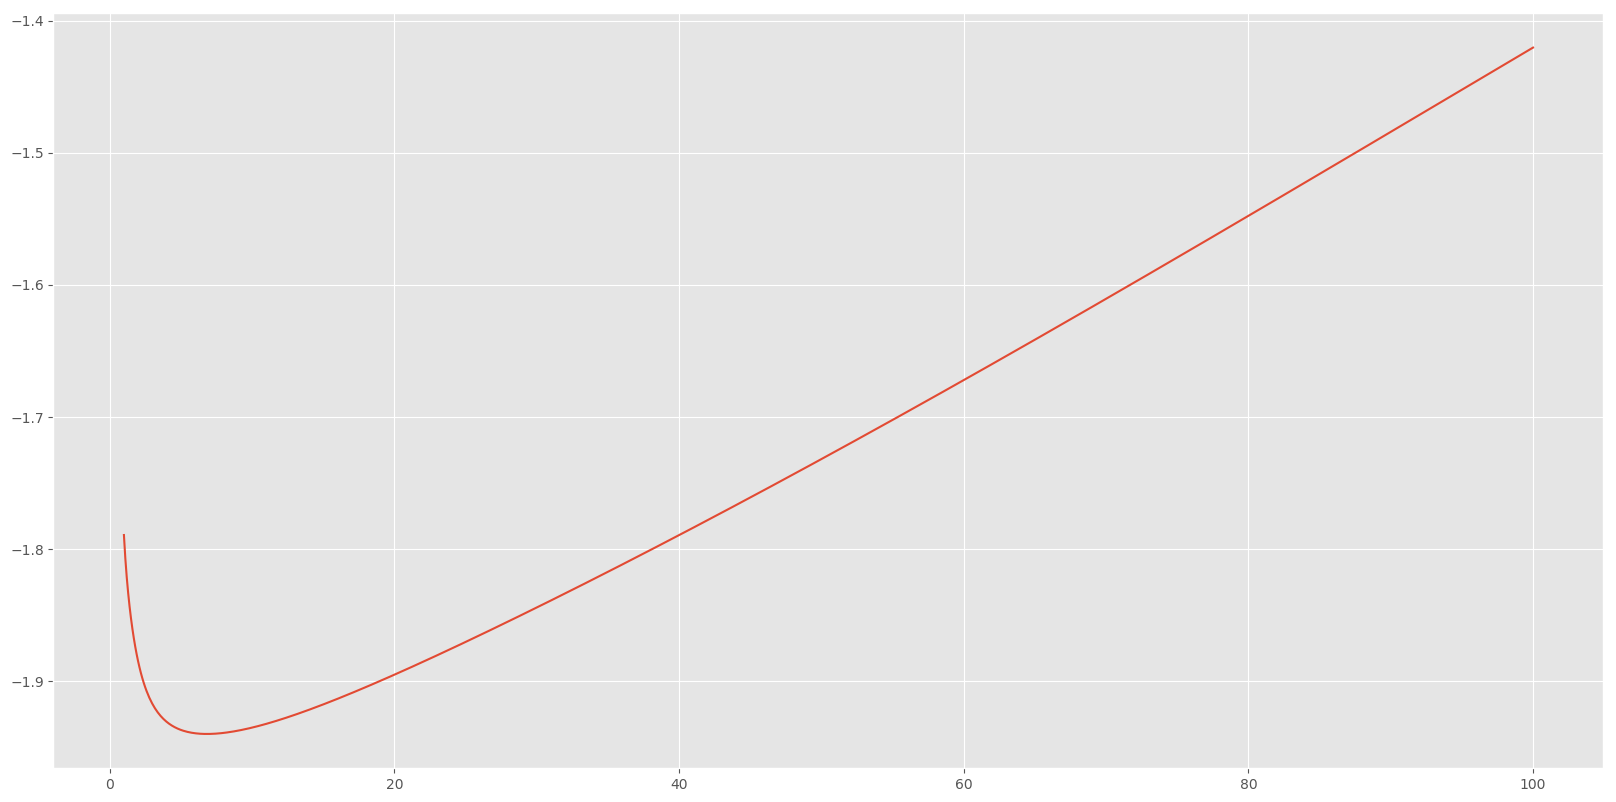

In [91]:
x=np.linspace(1,100,1000)
y=np.vectorize(laplace[1])(x).real

fig = plt.figure(figsize=(20,10),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#plt.yscale('log')
#plt.setp(linestyle='-', color='r', linewidth=2.0)
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'-')

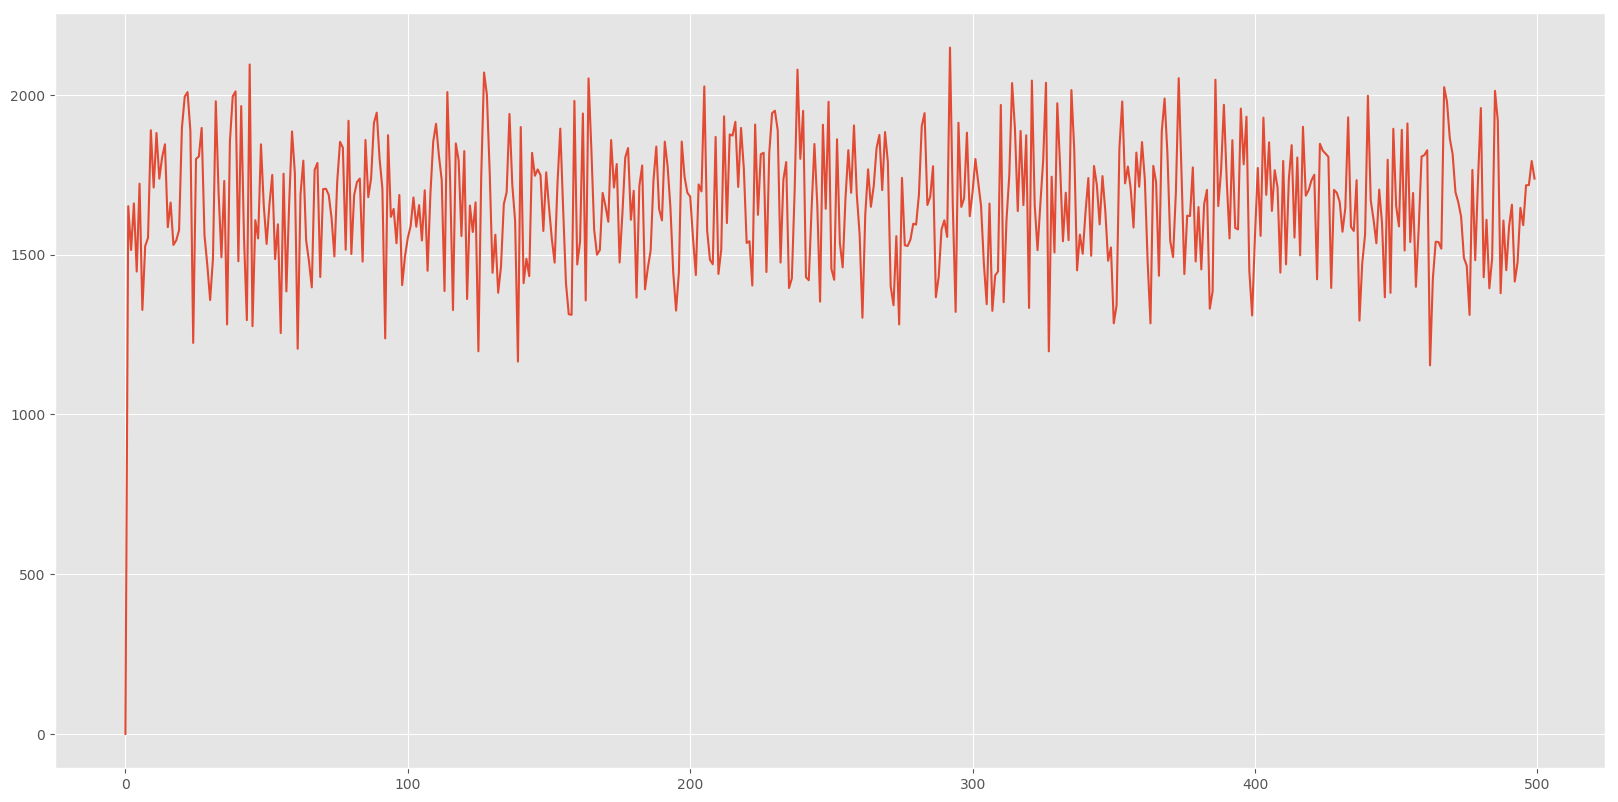

In [38]:
y=np.array([np.trapz(np.absolute(cwtcollection[0,10]-cwtcollection[idx,10])) for idx in range(500)])
x=np.arange(y.size)

fig = plt.figure(figsize=(20,10),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#plt.yscale('log')
#plt.setp(linestyle='-', color='r', linewidth=2.0)
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'-')

In [20]:
import pylab as pl
from sklearn import datasets

# load dataset
df = pd.DataFrame(TestClass.get_adjusted_fft_windowed())#, columns=[str(x) for x in range(500)])

# normalize data
data_scaled = pd.DataFrame(scale(df),columns = df.columns) 

# PCA
pca = PCA(n_components=10)
pca.fit_transform(data_scaled)

# Dump components relations with features:
#print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-'+str(i) for i in range(10)]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[-0.32639156,  0.91527019,  0.04423667, ..., -0.68472271,
        -0.09460551, -0.31689517],
       [-0.50975256,  0.26005317, -0.26725871, ...,  0.07713993,
        -0.28271076,  0.12284634],
       [-0.52577788, -1.21762354, -0.22376317, ...,  0.49021612,
         0.34988909, -0.098573  ],
       ...,
       [-0.44647357, -0.23755013,  0.51535911, ...,  0.02838382,
        -0.14161333, -0.0934124 ],
       [-0.48011849,  0.05345992, -0.90466619, ..., -0.05699181,
         0.05783089,  0.23863085],
       [-0.49247735, -0.35899365,  1.02622353, ..., -0.08577151,
        -0.19079608, -0.42195541]])

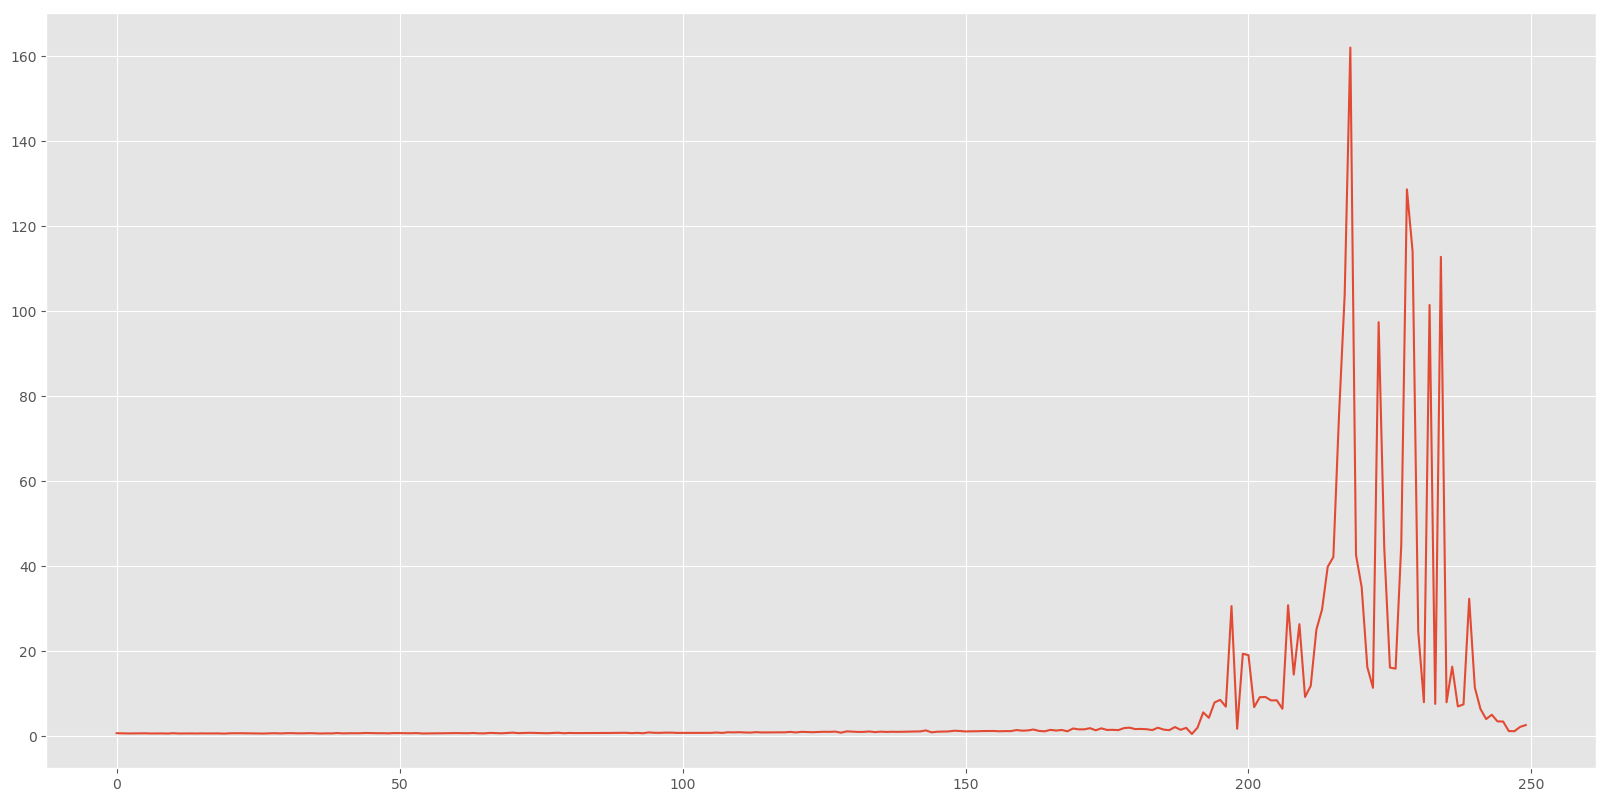

In [44]:
m=int(TestClass.series_size/2)

x,y=np.arange(m).reshape(-1,1),np.absolute(TestClass.get_fft()[100,m:])


fig = plt.figure(figsize=(20,10),dpi=100)
ax = fig.add_subplot(1, 1, 1)
#plt.yscale('log')
#plt.setp(linestyle='-', color='r', linewidth=2.0)
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'-')

Not my Stuff:

In [30]:
def reject_outliers(data,test, m ): #I guess a lot of the sparse cluster would be considered an outlier
    # i.e a couple stdev outside the mean, but that's not really what I'm going for. There are some 20 
    # outliers which are about 25 outside the median, and don't fall in this sort of rectangle. I don't 
    # want those. (But the sparse clusters probably have about 25% of the data, so I don't want to get rid of them)
    d = np.linalg.norm((data - np.median(data,axis=0)), axis=1)
    mdev = np.median(d,axis=0)
    s = d/mdev if mdev else 0.
    a=data[s<m,:]
    b=test[s<m]
    return (a,b)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


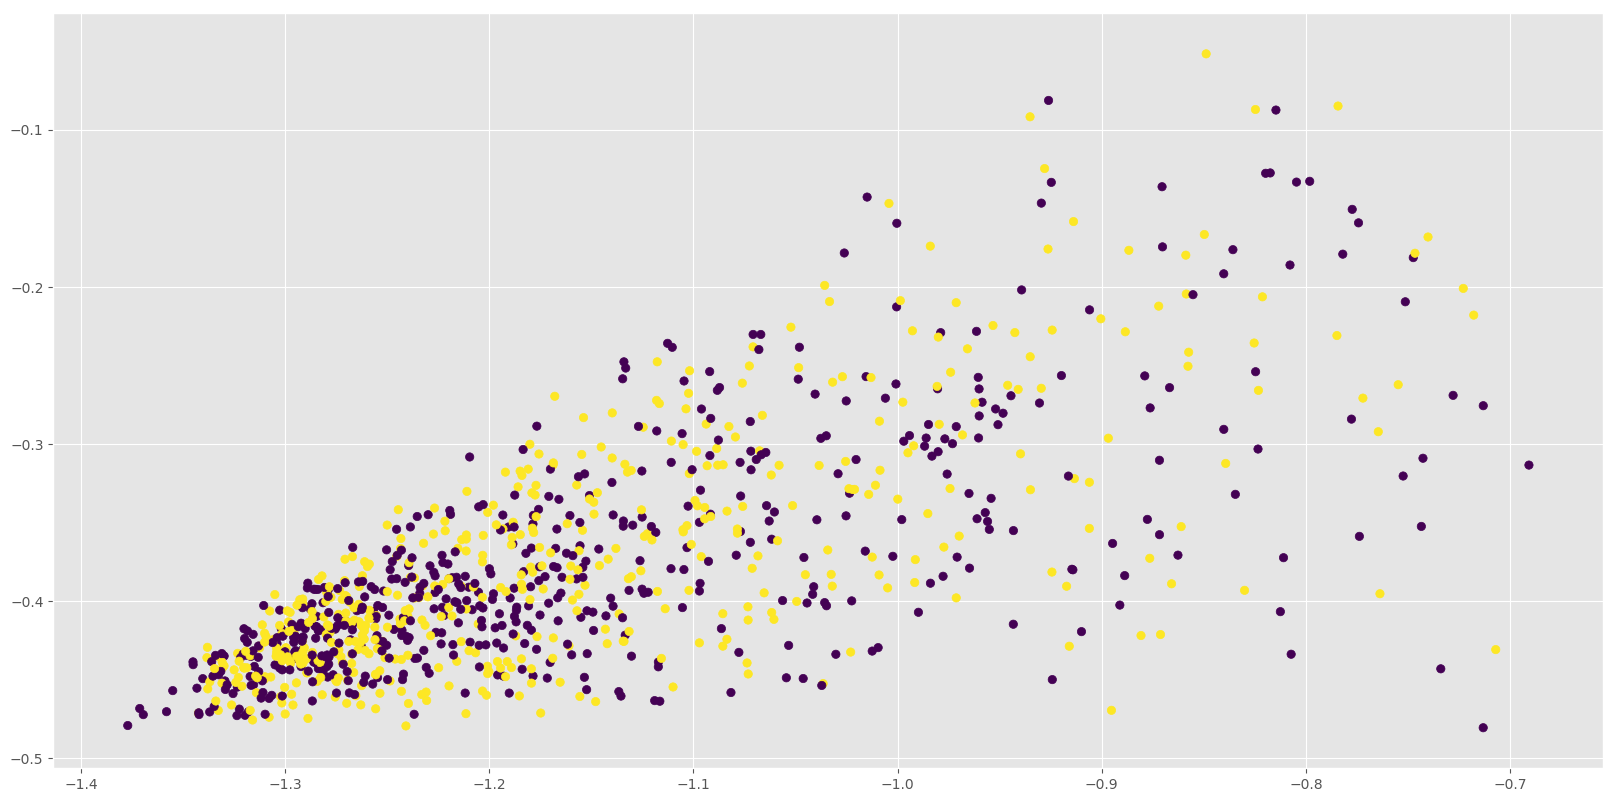

In [31]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, IncrementalPCA

X = scale(np.absolute(TestClass.get_adjusted_fft_windowed()[:,m:]))
y = TestClass.classes

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)










pca = PCA(n_components=n_components)
X_pca,y_pca = reject_outliers(pca.fit_transform(X),TestClass.classes,3)








fig = plt.figure(figsize=(20,10),dpi=100)
ax = fig.add_subplot(1, 1, 1)

m=int(TestClass.series_size/2)

x,y=np.arange(TestClass.sample_size).reshape(-1,1),np.absolute(TestClass.get_adjusted_fft_windowed()[:,m:])

plt.scatter(X_pca[:,0],X_pca[:,1], c=y_pca)


plt.show()



















In [32]:
X_pca.shape

(1039, 2)